In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:50% !important; }</style>"))

%matplotlib inline

import os
import re
import json
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from map4 import MAP4Calculator

In [2]:
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0'
#HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A}|PEPTIDE2{A.C.A.A.C.A}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0'
mol = Chem.MolFromHELM(HELM_string1)

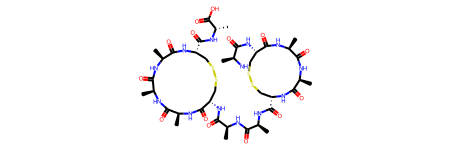

In [3]:
mol

In [18]:
with open('HELMCoreLibrary.json') as f:
    monomer_lib = json.load(f)

monomer_peptide_lib = [x for x in monomer_lib if x['polymerType'] == 'PEPTIDE']
AA1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
monomer_aa1_lib = [x for x in monomer_peptide_lib if x['symbol'] in AA1]

In [65]:
AA1.index('A')

0

In [91]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res


def map4_fingerprint(molecule_strings, input_type='fasta', dimensions=4096, radius=2, is_counted=False, is_folded=True):
    f = {'fasta': Chem.rdmolfiles.MolFromFASTA,
         'smiles': Chem.rdmolfiles.MolFromSmiles,
         'helm': Chem.rdmolfiles.MolFromHELM}
    
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([f[input_type](s) for s in molecule_strings])
    return torch.from_numpy(np.array(fps))

In [58]:
smiles = [monomer['smiles'] for monomer in monomer_aa1_lib]
fps = map4_fingerprint(smiles, radius=2)
t = TanimotoSimilarityKernel()
similarity_matrix = t.forward(fps, fps).numpy()

In [61]:
probability_matrix = []

for aa in similarity_matrix:
    tmp = aa.copy()
    tmp[tmp == 1.0] = 0
    probability_matrix.append(tmp / np.sum(tmp))
    
probability_matrix = np.array(probability_matrix)

In [80]:
def parse_helm(helm_string):
    dtype = [('SourcePolymerID', 'U20'), ('TargetPolymerID', 'U20'),
             ('SourceMonomerPosition', 'i4'), ('SourceAttachment', 'U2'),
             ('TargetMonomerPosition', 'i4'), ('TargetAttachment', 'U2')]
    
    polymers, connections, hydrogen_bonds, attributes, _ = helm_string.split('$')
    
    # Process sequences
    data = {}
    for polymer in polymers.split('|'):
        pid = polymer.split('{')[0]
        sequence = polymer[len(pid) + 1:-1].replace('.', '')
        data[pid] = sequence
        
    polymers = data
        
    # Process connections
    data = []
    if connections:
        for connection in connections.split('|'):
            source_id, target_id, con = connection.split(',')
            source_position, source_attachment = con.split('-')[0].split(':')
            target_position, target_attachment = con.split('-')[1].split(':')
            data.append((source_id, target_id,
                         source_position, source_attachment,
                         target_position, target_attachment))
        
    connections = np.array(data, dtype=dtype)
    
    return polymers, connections, hydrogen_bonds, attributes


def build_helm_string(polymers, connections):
    sequences_str = '|'.join(['%s{%s}' % (p, '.'.join(s)) for p, s in polymers.items()])
    if len(connections) > 0:
        connections_str = '|'.join(['%s,%s,%d:%s-%d:%s' % (c[0], c[1], c[2], c[3], c[4], c[5]) for c in connections])
    else:
        connections_str = ''
    helm_string = '%s$%s$$$V2.0' % (sequences_str, connections_str)
    
    return helm_string


class HELMGeneticOperators:
    
    def __init__(self, monomer_library, probability_matrix=None, seed=None):
        self._monomer_library = monomer_library
        self._monomer_symbols = [m['symbol'] for m in self._monomer_library]
        self._probability_matrix = probability_matrix
        
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)
        self._connections_dtype = [('SourcePolymerID', 'U20'), ('TargetPolymerID', 'U20'),
                                   ('SourceMonomerPosition', 'i4'), ('SourceAttachment', 'U2'),
                                   ('TargetMonomerPosition', 'i4'), ('TargetAttachment', 'U2')]
        
    def insert(self, helm_string, probability=0.05, only_terminus=False, maximum_size=None):
        mutant_polymers = {}
        n_mutations = 0
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        for pid, sequence in polymers.items():
            mutated_sequence = list(sequence)
            
            if only_terminus:
                possible_positions = np.array([0, len(sequence)])
            else:
                possible_positions = np.array(range(len(sequence)))
            
            # Choose positions to insert
            mutation_probabilities = self._rng.uniform(size=len(possible_positions))
            mutation_positions = possible_positions[mutation_probabilities <= probability]
            
            # We move to the next polymer if there is no monomer to insert...
            if len(mutation_positions) == 0:
                mutant_polymers[pid] = (sequence, np.array([]))
                continue
            
            if maximum_size is not None:
                # In the case where mutation_positions is smaller than diff maximum_size and sequence
                mutations_to_select = np.min([maximum_size - len(sequence), len(mutation_positions)])

                if mutations_to_select > 0:
                    mutation_positions = self._rng.choice(mutation_positions, size=mutations_to_select, replace=False)
                else:
                    # We move to the next polymer since the sequence length exceed already the maximum length allowed
                    mutant_polymers[pid] = (sequence, np.array([]))
                    continue
                
            for mutation_position in mutation_positions[::-1]:
                chosen_monomer = self._monomer_library[self._rng.choice(len(self._monomer_library))]['symbol']
                mutated_sequence.insert(mutation_position, chosen_monomer)
            
            mutant_polymers[pid] = (''.join(mutated_sequence), mutation_positions)
            n_mutations += len(mutation_positions)
        
        if n_mutations > 0:
            data = []

            # Shift attachment positions
            for i, connection in enumerate(connections):
                source_mutations = mutant_polymers[connection['SourcePolymerID']][1]
                target_mutations = mutant_polymers[connection['TargetPolymerID']][1]

                source_position = connection['SourceMonomerPosition'] + np.sum([source_mutations < connection['SourceMonomerPosition']])
                target_position = connection['TargetMonomerPosition'] + np.sum([target_mutations < connection['TargetMonomerPosition']])

                data.append((connection['SourcePolymerID'], connection['TargetPolymerID'], 
                             source_position, connection['SourceAttachment'],
                             target_position, connection['TargetAttachment']))

            new_connections = np.array(data, dtype=self._connections_dtype)

            # Reconstruct the HELM string
            mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, new_connections)

            return mutant_helm_string
        else:
            return helm_string
        
    def remove(self, helm_string, probability=0.05, only_terminus=False, minimun_size=None, keep_connections=True):
        mutant_polymers = {}
        n_mutations = 0
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        for pid, sequence in polymers.items():
            mutated_sequence = list(sequence)
            
            if only_terminus:
                possible_positions = [0, len(sequence) - 1]
            else:
                possible_positions = range(len(sequence))
                
            # Residues involved in a connection within and between polymers won't be removed
            if keep_connections and pid in polymers.keys():
                connection_resids = list(connections[connections['SourcePolymerID'] == pid]['SourceMonomerPosition'])
                connection_resids += list(connections[connections['TargetPolymerID'] == pid]['TargetMonomerPosition'])
                # Because positions are 1-based in HELM
                connection_resids = np.array(connection_resids) - 1
                possible_positions = list(set(possible_positions).difference(connection_resids))
            
            # Choose positions to remove
            possible_positions = np.array(possible_positions)
            mutation_probabilities = self._rng.uniform(size=len(possible_positions))
            mutation_positions = possible_positions[mutation_probabilities <= probability]
            
            # We move to the next polymer if there is no monomer to remove...
            if len(mutation_positions) == 0:
                mutant_polymers[pid] = (sequence, np.array([]))
                continue
            
            if minimun_size is not None:
                # In the case where mutation_positions is smaller than diff maximum_size and sequence
                mutations_to_select = np.min([len(sequence) - minimun_size, len(mutation_positions)])

                if mutations_to_select > 0:
                    mutation_positions = self._rng.choice(mutation_positions, size=mutations_to_select, replace=False)
                else:
                    # We move to the next polymer since the sequence length exceed already the maximum length allowed
                    mutant_polymers[pid] = (sequence, np.array([]))
                    continue
            
            # Since we are going to remove from the end, the array must be sorted
            mutation_positions = np.sort(mutation_positions)
                
            for mutation_position in mutation_positions[::-1]:
                mutated_sequence.pop(mutation_position)
            
            mutant_polymers[pid] = (''.join(mutated_sequence), mutation_positions)
            n_mutations += len(mutation_positions)
        
        if n_mutations > 0:
            connections_to_keep = []
            data = []
                
            # Check if we have to remove connections due to the monomers removed
            for i, connection in enumerate(connections):
                # The connection positions must not be in the mutation lists
                # mutant_polymers[connection['XXXXXPolymerID']][1] + 1 because positions are 1-based in HELM
                if connection['SourceMonomerPosition'] not in mutant_polymers[connection['SourcePolymerID']][1] + 1 and \
                   connection['TargetMonomerPosition'] not in mutant_polymers[connection['TargetPolymerID']][1] + 1:
                    connections_to_keep.append(i)
                        
            # Shift attachment positions (only the connections to keep)
            for i, connection in enumerate(connections[connections_to_keep]):
                source_mutations = mutant_polymers[connection['SourcePolymerID']][1]
                target_mutations = mutant_polymers[connection['TargetPolymerID']][1]

                source_position = connection['SourceMonomerPosition'] - np.sum([source_mutations < connection['SourceMonomerPosition']])
                target_position = connection['TargetMonomerPosition'] - np.sum([target_mutations < connection['TargetMonomerPosition']])

                data.append((connection['SourcePolymerID'], connection['TargetPolymerID'], 
                             source_position, connection['SourceAttachment'],
                             target_position, connection['TargetAttachment']))

            new_connections = np.array(data, dtype=self._connections_dtype)

            # Reconstruct the HELM string
            mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, new_connections)
            
            return mutant_helm_string
        else:
            return helm_string
        
    def mutate(self, helm_string, n=10, minimum_mutations=1, maximum_mutations=None, keep_connections=True):
        mutant_helm_strings = []
        
        polymers, connections, _, _ = parse_helm(helm_string)
        
        # Generate mutants...
        for i in range(n):
            mutant_polymers = {}
            n_mutations = 0
            
            for pid, sequence in polymers.items():
                mutated_sequence = list(sequence)
                
                # Residues involved in a connection within and between peptides won't be mutated
                if keep_connections and pid in polymers.keys():
                    connection_resids = list(connections[connections['SourcePolymerID'] == pid]['SourceMonomerPosition'])
                    connection_resids += list(connections[connections['TargetPolymerID'] == pid]['TargetMonomerPosition'])
                    # Because positions are 1-based in HELM
                    connection_resids = np.array(connection_resids) - 1
                    
                    possible_positions = list(set(range(len(sequence))).difference(connection_resids))
                else:
                    possible_positions = list(range(len(sequence)))
                
                # Choose a random number of mutations between min and max
                if minimum_mutations == maximum_mutations:
                    number_mutations = maximum_mutations
                elif maximum_mutations is None:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=len(sequence))
                else:
                    number_mutations = self._rng.integers(low=minimum_mutations, high=maximum_mutations)
                
                # Choose positions to mutate
                mutation_positions = self._rng.choice(possible_positions, size=number_mutations, replace=False)
                
                # Do mutations
                for mutation_position in mutation_positions:                    
                    monomer_symbol = mutated_sequence[mutation_position]
                    
                    # Force mutation!
                    while monomer_symbol == mutated_sequence[mutation_position]:
                        # Instead of mutating to random monomer, the selection will be
                        # based on the probability matrix
                        if self._probability_matrix is not None:
                            index_symbol = self._monomer_symbols.index(monomer_symbol)
                            p = probability_matrix[index_symbol]
                        else:
                            p = None
                        
                        chosen_monomer = self._rng.choice(self._monomer_symbols, p=p)
                        mutated_sequence[mutation_position] = chosen_monomer
                
                mutant_polymers[pid] = (mutated_sequence, mutation_positions)
                n_mutations += len(mutation_positions)
            
            if n_mutations > 0:
                if not keep_connections:
                    connections_to_keep = []

                    # Check if we have to remove connections due to the mutations
                    for i, connection in enumerate(connections):
                        # The connection positions must not be in the mutation lists
                        # mutant_polymers[connection['XXXXXPolymerID']][1] + 1 because positions are 1-based in HELM
                        if connection['SourceMonomerPosition'] not in mutant_polymers[connection['SourcePolymerID']][1] + 1 and \
                           connection['TargetMonomerPosition'] not in mutant_polymers[connection['TargetPolymerID']][1] + 1:
                            connections_to_keep.append(i)
                else:
                    connections_to_keep = list(range(connections.shape[0]))

                # Reconstruct the HELM string
                mutant_helm_string = build_helm_string({p: s[0] for p, s in mutant_polymers.items()}, connections[connections_to_keep])
                mutant_helm_strings.append(mutant_helm_string)
            else:
                mutant_helm_strings.append(helm_string)
        
        return mutant_helm_strings
            

In [6]:
m = HELMGeneticOperators(monomer_aa1_lib)
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0'
mutants = m.remove(HELM_string1, probability=1, minimun_size=10, only_terminus=True, keep_connections=False)

print(mutants)

PEPTIDE1{C.A.A.C.A.A.C.A.A.A.C}$PEPTIDE1,PEPTIDE1,1:R3-4:R3|PEPTIDE1,PEPTIDE1,7:R3-11:R3$$$V2.0


In [7]:
m = HELMGeneticOperators(monomer_aa1_lib)
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A}|PEPTIDE2{A.C.A.A.C.A}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0'
mutants = m.remove(HELM_string1, probability=0.1, minimun_size=None, only_terminus=False, keep_connections=False)

print(mutants)

PEPTIDE1{A.C.A.A.A}|PEPTIDE2{A.C.A.A.C.A}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0


In [8]:
m = HELMGeneticOperators(monomer_aa1_lib)
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0'
mutants = m.insert(HELM_string1, maximum_size=16, only_terminus=True)

print(mutants)

PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0


In [9]:
m = HELMGeneticOperators(monomer_aa1_lib)
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A}|PEPTIDE2{A.C.A.A.C.A}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0'
mutants = m.insert(HELM_string1, maximum_size=16, only_terminus=False)

print(mutants)

PEPTIDE1{A.Q.C.A.A.C.A}|PEPTIDE2{A.C.A.A.C.A}$PEPTIDE1,PEPTIDE2,3:R3-5:R3$$$V2.0


In [10]:
m = HELMGeneticOperators(monomer_aa1_lib)
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0'
mutants = m.mutate(HELM_string1, minimum_mutations=1, maximum_mutations=2, keep_connections=False)

for mutant in mutants:
    print(mutant)

PEPTIDE1{A.C.I.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.A.A.C.A.N.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.F.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.A.A.C.A.A.C.A.A.A.P.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3$$$V2.0
PEPTIDE1{A.C.D.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.A.A.C.A.A.C.P.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.A.A.C.A.C.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.A.A.C.A.F.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.W.A.C.A.A.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0
PEPTIDE1{A.C.A.A.C.A.N.C.A.A.A.C.A}$PEPTIDE1,PEPTIDE1,2:R3-5:R3|PEPTIDE1,PEPTIDE1,8:R3-12:R3$$$V2.0


In [11]:
m = HELMGeneticOperators(monomer_aa1_lib)
HELM_string1 = 'PEPTIDE1{A.C.A.A.C.A}|PEPTIDE2{A.C.A.A.C.A}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0'
mutants = m.mutate(HELM_string1, minimum_mutations=2, maximum_mutations=2, keep_connections=False)

for mutant in mutants:
    print(mutant)

PEPTIDE1{A.C.R.T.C.A}|PEPTIDE2{A.G.A.A.E.A}$$$$V2.0
PEPTIDE1{A.F.A.A.E.A}|PEPTIDE2{A.C.K.A.C.V}$$$$V2.0
PEPTIDE1{A.L.A.A.W.A}|PEPTIDE2{A.C.K.M.C.A}$$$$V2.0
PEPTIDE1{A.C.Y.A.A.A}|PEPTIDE2{S.C.A.C.C.A}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0
PEPTIDE1{R.K.A.A.C.A}|PEPTIDE2{D.C.Q.A.C.A}$$$$V2.0
PEPTIDE1{Y.C.A.F.C.A}|PEPTIDE2{A.C.S.N.C.A}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0
PEPTIDE1{A.C.A.A.W.P}|PEPTIDE2{A.C.A.A.M.R}$$$$V2.0
PEPTIDE1{W.C.A.A.C.H}|PEPTIDE2{A.C.A.A.A.F}$$$$V2.0
PEPTIDE1{A.F.H.A.C.A}|PEPTIDE2{S.Q.A.A.C.A}$$$$V2.0
PEPTIDE1{A.C.Q.A.C.V}|PEPTIDE2{A.K.A.A.C.F}$PEPTIDE1,PEPTIDE2,2:R3-5:R3$$$V2.0


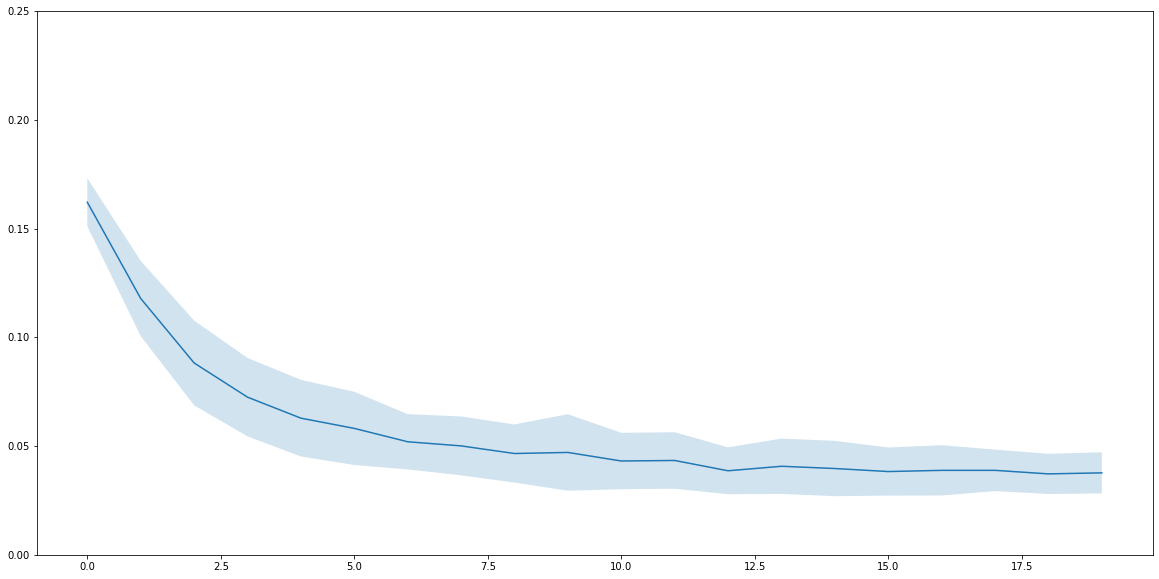

In [195]:
k = TanimotoSimilarityKernel()
m = HELMGeneticOperators(monomer_aa1_lib, probability_matrix=probability_matrix)

gt = []

for _ in range(50):
    n = 20
    HELM_string = 'PEPTIDE1{A.A.A.A.A.A}$$$$V2.0'

    fps = map4_fingerprint([HELM_string], input_type='helm')

    t = []

    for i in range(n):
        mutants = m.mutate(HELM_string, minimum_mutations=1, maximum_mutations=3)

        fps_mutants = map4_fingerprint(mutants, input_type='helm')
        mat = k.forward(fps, fps_mutants)

        t.append(np.mean(mat.numpy()))

        HELM_string = mutants[0]
    
    gt.append(t)

gt = np.array(gt)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(np.arange(0, n), np.mean(gt, axis=0))
plt.fill_between(np.arange(0, n), np.mean(gt, axis=0) - np.std(gt, axis=0), np.mean(gt, axis=0) + np.std(gt, axis=0), alpha=0.2)
ax.set_ylim([0, 0.25])
plt.show()

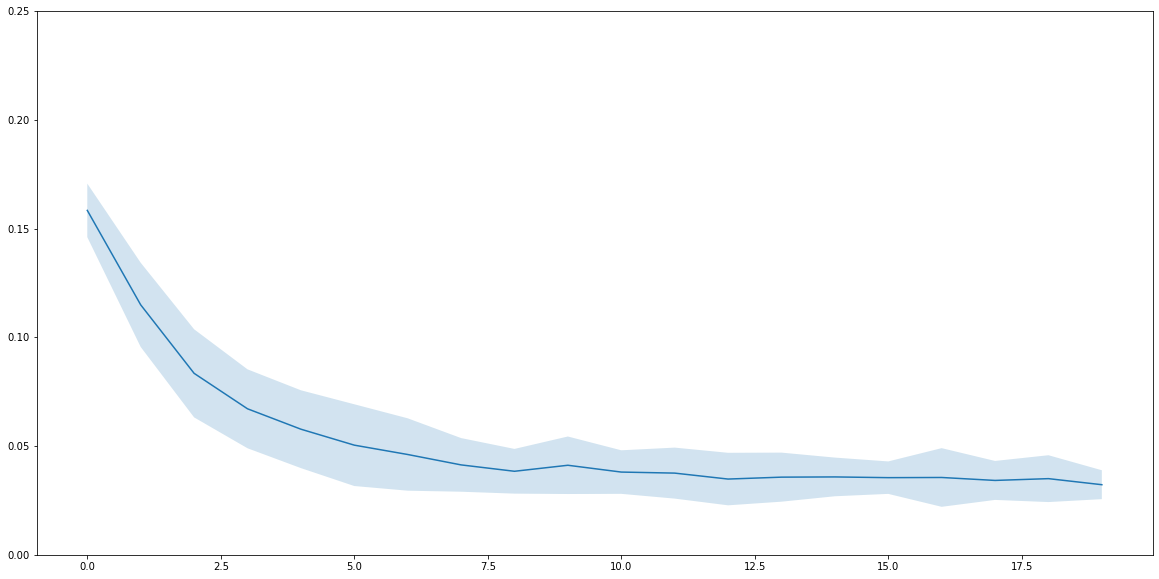

In [196]:
k = TanimotoSimilarityKernel()
m = HELMGeneticOperators(monomer_aa1_lib, probability_matrix=None)

gt = []

for _ in range(50):
    n = 20
    HELM_string = 'PEPTIDE1{A.A.A.A.A.A}$$$$V2.0'

    fps = map4_fingerprint([HELM_string], input_type='helm')

    t = []

    for i in range(n):
        mutants = m.mutate(HELM_string, minimum_mutations=1, maximum_mutations=3)

        fps_mutants = map4_fingerprint(mutants, input_type='helm')
        mat = k.forward(fps, fps_mutants)

        t.append(np.mean(mat.numpy()))

        HELM_string = mutants[0]
    
    gt.append(t)

gt = np.array(gt)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(np.arange(0, n), np.mean(gt, axis=0))
plt.fill_between(np.arange(0, n), np.mean(gt, axis=0) - np.std(gt, axis=0), np.mean(gt, axis=0) + np.std(gt, axis=0), alpha=0.2)
ax.set_ylim([0, 0.25])
plt.show()

In [149]:
HELM_string = 'PEPTIDE1{A.A.A.A.A.A}$$$$V2.0'

m = HELMGeneticOperators(monomer_aa1_lib, probability_matrix=probability_matrix)
all_mutants = [HELM_string]
colors = [-1]
n = 20

for i in range(n):
    print(HELM_string)
    mutants = m.mutate(HELM_string, minimum_mutations=1, maximum_mutations=1)

    for mutant in mutants:
        print(mutant)
    
    HELM_string = mutants[0]
    all_mutants.extend(mutants)
    colors.extend([i + 1] * 10)
    
    print()

PEPTIDE1{A.A.A.A.A.A}$$$$V2.0
PEPTIDE1{A.A.A.E.A.A}$$$$V2.0
PEPTIDE1{A.A.V.A.A.A}$$$$V2.0
PEPTIDE1{A.E.A.A.A.A}$$$$V2.0
PEPTIDE1{A.A.A.D.A.A}$$$$V2.0
PEPTIDE1{A.A.M.A.A.A}$$$$V2.0
PEPTIDE1{A.A.A.F.A.A}$$$$V2.0
PEPTIDE1{A.A.A.A.E.A}$$$$V2.0
PEPTIDE1{V.A.A.A.A.A}$$$$V2.0
PEPTIDE1{A.A.S.A.A.A}$$$$V2.0
PEPTIDE1{A.L.A.A.A.A}$$$$V2.0

PEPTIDE1{A.A.A.E.A.A}$$$$V2.0
PEPTIDE1{A.A.D.E.A.A}$$$$V2.0
PEPTIDE1{A.A.A.E.S.A}$$$$V2.0
PEPTIDE1{A.A.A.Q.A.A}$$$$V2.0
PEPTIDE1{A.A.I.E.A.A}$$$$V2.0
PEPTIDE1{A.T.A.E.A.A}$$$$V2.0
PEPTIDE1{A.M.A.E.A.A}$$$$V2.0
PEPTIDE1{A.A.A.E.A.V}$$$$V2.0
PEPTIDE1{A.A.A.E.C.A}$$$$V2.0
PEPTIDE1{A.P.A.E.A.A}$$$$V2.0
PEPTIDE1{A.A.L.E.A.A}$$$$V2.0

PEPTIDE1{A.A.D.E.A.A}$$$$V2.0
PEPTIDE1{A.A.D.K.A.A}$$$$V2.0
PEPTIDE1{M.A.D.E.A.A}$$$$V2.0
PEPTIDE1{A.A.K.E.A.A}$$$$V2.0
PEPTIDE1{A.A.D.A.A.A}$$$$V2.0
PEPTIDE1{A.A.D.K.A.A}$$$$V2.0
PEPTIDE1{R.A.D.E.A.A}$$$$V2.0
PEPTIDE1{M.A.D.E.A.A}$$$$V2.0
PEPTIDE1{A.A.Q.E.A.A}$$$$V2.0
PEPTIDE1{A.A.L.E.A.A}$$$$V2.0
PEPTIDE1{V.A.D.E.A.A}$$$$V2.0

PEPTIDE

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


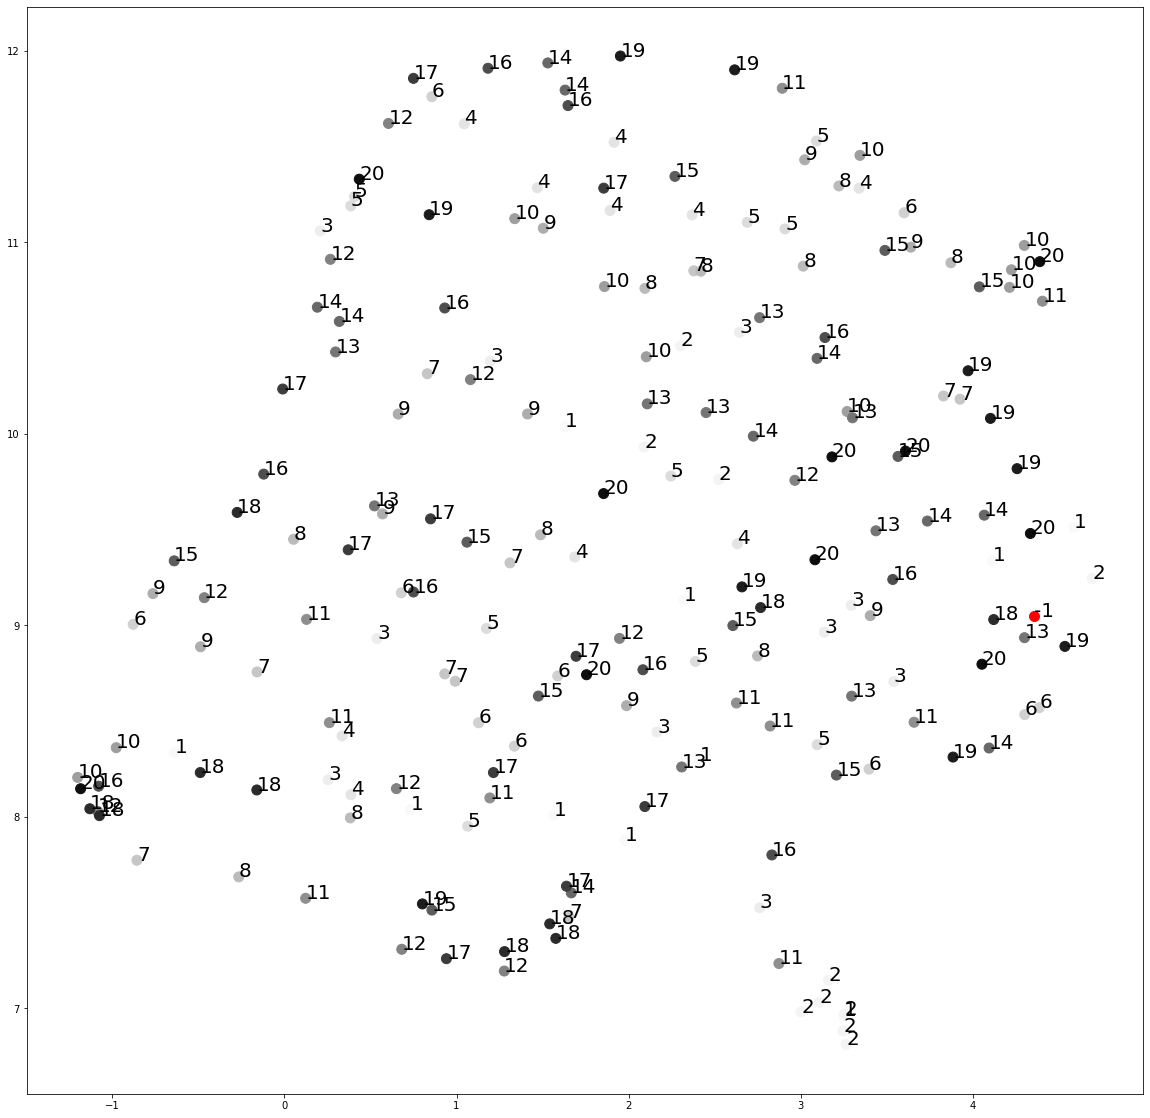

In [144]:
fps = map4_fingerprint(all_mutants, input_type='helm')

k = TanimotoSimilarityKernel()
mat = k.forward(fps, fps)

fit = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='precomputed')
u = fit.fit_transform(mat)

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=100, c=colors, vmin=0, vmax=n+1, cmap='Greys')
ax.scatter(u[0,0], u[0,1], s=100, c='red')

for i, txt in enumerate(u):
    ax.annotate(colors[i], (u[i,0], u[i,1]), fontsize=20)

plt.show()

In [145]:
HELM_string = 'PEPTIDE1{A.A.A.A.A.A}$$$$V2.0'

m = HELMGeneticOperators(monomer_aa1_lib, probability_matrix=None)
all_mutants = [HELM_string]
colors = [-1]
n = 20

for i in range(n):
    print(HELM_string)
    mutants = m.mutate(HELM_string, minimum_mutations=1, maximum_mutations=1)

    for mutant in mutants:
        print(mutant)
    
    HELM_string = mutants[0]
    all_mutants.extend(mutants)
    colors.extend([i + 1] * 10)
    
    print()

PEPTIDE1{A.A.A.A.A.A}$$$$V2.0
PEPTIDE1{A.A.A.A.N.A}$$$$V2.0
PEPTIDE1{A.Q.A.A.A.A}$$$$V2.0
PEPTIDE1{A.A.A.A.W.A}$$$$V2.0
PEPTIDE1{A.D.A.A.A.A}$$$$V2.0
PEPTIDE1{A.A.A.A.A.L}$$$$V2.0
PEPTIDE1{A.A.A.N.A.A}$$$$V2.0
PEPTIDE1{A.A.A.P.A.A}$$$$V2.0
PEPTIDE1{A.A.G.A.A.A}$$$$V2.0
PEPTIDE1{A.A.A.R.A.A}$$$$V2.0
PEPTIDE1{A.A.A.A.A.P}$$$$V2.0

PEPTIDE1{A.A.A.A.N.A}$$$$V2.0
PEPTIDE1{A.A.P.A.N.A}$$$$V2.0
PEPTIDE1{A.A.T.A.N.A}$$$$V2.0
PEPTIDE1{A.A.A.A.M.A}$$$$V2.0
PEPTIDE1{A.G.A.A.N.A}$$$$V2.0
PEPTIDE1{A.A.F.A.N.A}$$$$V2.0
PEPTIDE1{A.P.A.A.N.A}$$$$V2.0
PEPTIDE1{A.A.A.A.N.G}$$$$V2.0
PEPTIDE1{A.A.A.P.N.A}$$$$V2.0
PEPTIDE1{A.A.A.R.N.A}$$$$V2.0
PEPTIDE1{A.A.D.A.N.A}$$$$V2.0

PEPTIDE1{A.A.P.A.N.A}$$$$V2.0
PEPTIDE1{A.A.P.A.I.A}$$$$V2.0
PEPTIDE1{A.H.P.A.N.A}$$$$V2.0
PEPTIDE1{A.A.P.T.N.A}$$$$V2.0
PEPTIDE1{A.A.P.A.N.K}$$$$V2.0
PEPTIDE1{A.A.P.A.N.E}$$$$V2.0
PEPTIDE1{A.A.P.A.N.S}$$$$V2.0
PEPTIDE1{A.A.R.A.N.A}$$$$V2.0
PEPTIDE1{A.A.L.A.N.A}$$$$V2.0
PEPTIDE1{A.A.A.A.N.A}$$$$V2.0
PEPTIDE1{A.A.P.A.M.A}$$$$V2.0

PEPTIDE

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


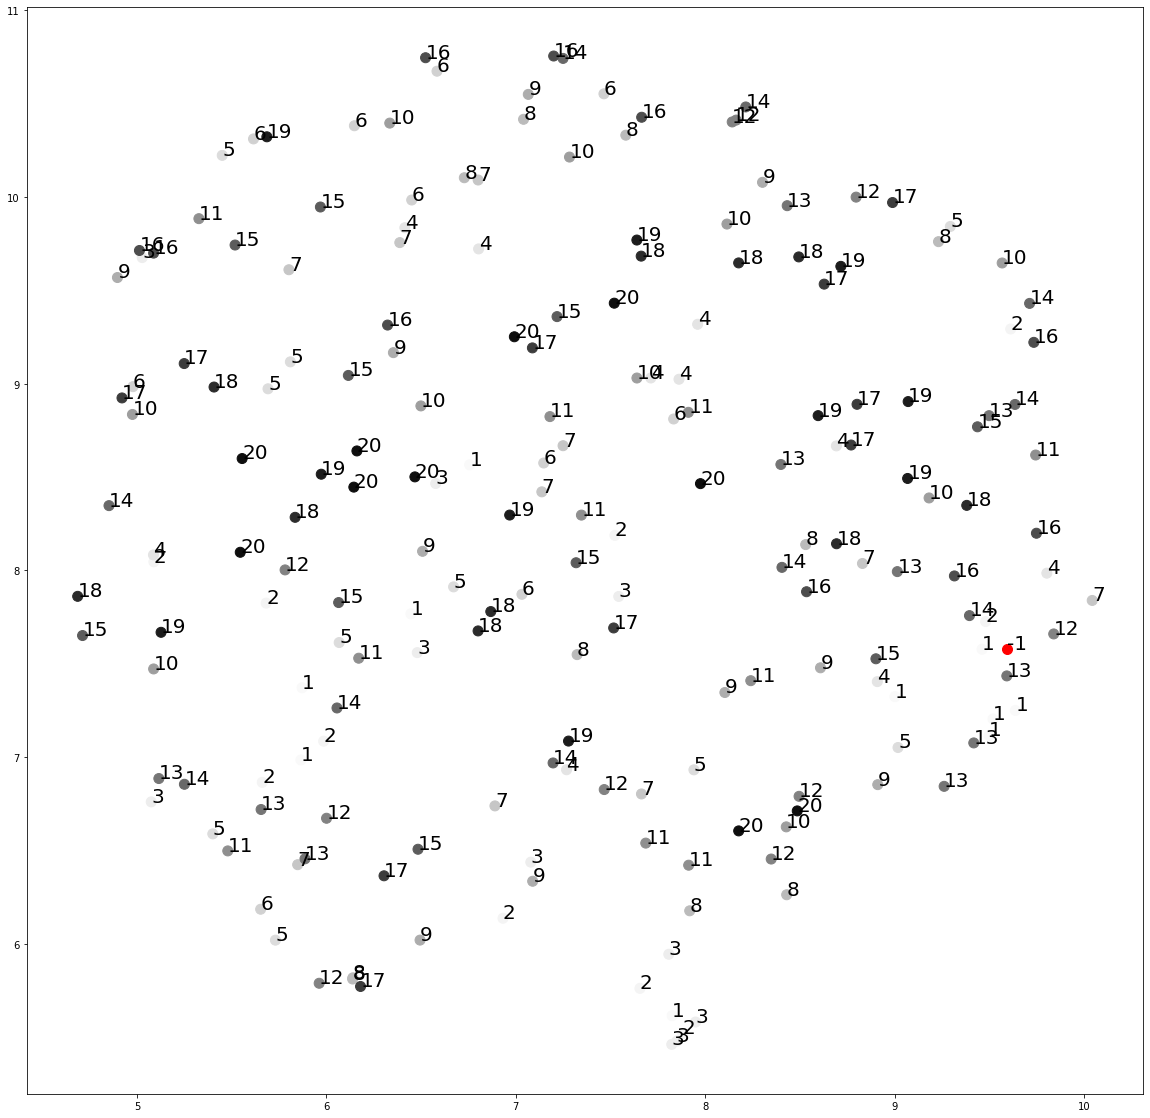

In [146]:
fps = map4_fingerprint(all_mutants, input_type='helm')

k = TanimotoSimilarityKernel()
mat = k.forward(fps, fps)

fit = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='precomputed')
u = fit.fit_transform(mat)

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=100, c=colors, vmin=0, vmax=n+1, cmap='Greys')
ax.scatter(u[0,0], u[0,1], s=100, c='red')

for i, txt in enumerate(u):
    ax.annotate(colors[i], (u[i,0], u[i,1]), fontsize=20)

plt.show()